In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mlp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
import shap


In [3]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    'mathtext.fontset': 'cm'
})

In [4]:
shap_red = shap.plots.colors.red_rgb
shap_blue = shap.plots.colors.blue_rgb
shap_gray = shap.plots.colors.gray_rgb
shap_cmap = shap.plots.colors.red_blue
shap_discrete_cmap = mlp.ListedColormap([shap_blue, shap_red])
shap_multi_discrete_map = mlp.ListedColormap([np.array(shap_cmap(a))[:-1] for a in np.linspace(0,1,4)])

In [5]:
X = pd.read_csv("data/X_large.csv")
y = np.load("data/y_new.npy")

In [6]:
X_toy = X[['sex_isFemale', 'age', 'systolic_blood_pressure', 'BMI']].copy()
X_toy = X_toy.dropna()
X_toy = X_toy.sample(n = 1250, replace = False, random_state = 42, axis = 0)
y_toy = y[X_toy.index]
X_toy = X_toy.reset_index(drop = True)

In [7]:
col_labels = ['Female', 'Age', 'Systolic BP', 'BMI']

In [8]:
(X_train, X_test, y_train, y_test) = train_test_split(X_toy, y_toy, test_size = 0.2, shuffle = True, random_state = 3394)

## Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [11]:
print('Intercept :\n', lr.intercept_[0])
for i in range(len(X_toy.columns)):
    print(col_labels[i], ':\n', lr.coef_[0][i])

Intercept :
 -8.201724514485505
Female :
 -0.72029217106936
Age :
 0.09347817253620982
Systolic BP :
 0.016879304922653583
BMI :
 -0.007424291549965791


In [12]:
np.exp(-0.721)

0.4862657469990346

In [13]:
np.exp(0.093)

1.097461735268082

## GAM 

In [16]:
from pygam import LogisticGAM, s, l

In [17]:
loggam = LogisticGAM(l(0) + s(1) + s(2) + s(3)).fit(X_train, y_train)

In [18]:
female_gam_grid = pd.DataFrame({'feature': loggam.generate_X_grid(term = 0)[:,0], 'effect': loggam.partial_dependence(term=0, X=loggam.generate_X_grid(term = 0))})
age_gam_grid = pd.DataFrame({'feature': loggam.generate_X_grid(term = 1)[:,1], 'effect': loggam.partial_dependence(term=1, X=loggam.generate_X_grid(term = 1))})
sbp_gam_grid = pd.DataFrame({'feature': loggam.generate_X_grid(term = 2)[:,2], 'effect': loggam.partial_dependence(term=2, X=loggam.generate_X_grid(term = 2))})
bmi_gam_grid = pd.DataFrame({'feature': loggam.generate_X_grid(term = 3)[:,3], 'effect': loggam.partial_dependence(term=3, X=loggam.generate_X_grid(term = 3))})

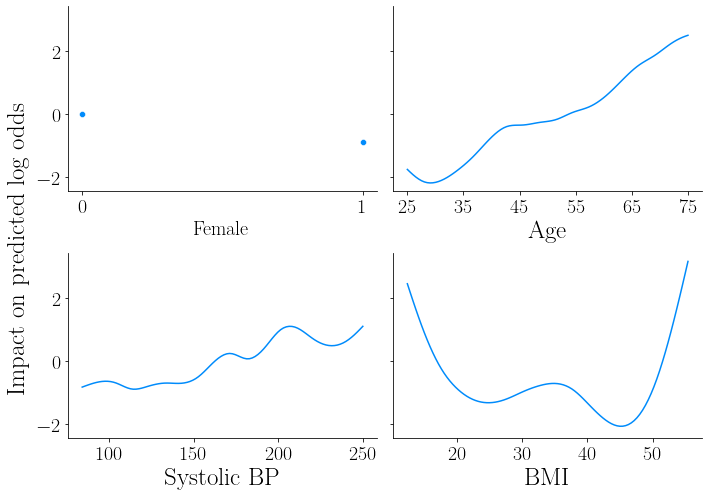

In [19]:
fig, axs = plt.subplots(2,2, figsize = (10, 7), sharey=True)
ax1 = sns.scatterplot(data = female_gam_grid.iloc[[0,-1],:], x = 'feature', y = 'effect', ax = axs[0,0], color = shap_blue)
ax1.set_xlabel(col_labels[0], fontsize = 20) 
ax1.set_ylabel("") 
ax1.set_xticks([0,1])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis = 'both', labelsize = 20)
ax2 = sns.lineplot(data = age_gam_grid, x = 'feature', y = 'effect', ax = axs[0,1], color = shap_blue)
ax2.set_xlabel(col_labels[1], fontsize = 25) 
ax2.set_xticks([25,35,45,55,65,75]) 
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis = 'both', labelsize = 20)
ax3 = sns.lineplot(data = sbp_gam_grid, x = 'feature', y = 'effect', ax = axs[1,0], color = shap_blue)
ax3.set_xlabel(col_labels[2], fontsize = 25) 
ax3.set_ylabel("") 
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(axis = 'both', labelsize = 20)
ax4 = sns.lineplot(data = bmi_gam_grid, x = 'feature', y = 'effect', ax = axs[1,1], color = shap_blue)
ax4.set_xlabel(col_labels[3], fontsize = 25) 
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.tick_params(axis = 'both', labelsize = 20)
fig.supylabel('Impact on predicted log odds', fontsize = 25)
fig.tight_layout()
plt.show()

## Classification tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [23]:
dt = DecisionTreeClassifier(random_state=42)

In [24]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [25]:
dt.get_depth()

17

In [26]:
dt = DecisionTreeClassifier(random_state=42, max_depth=2)

In [27]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [28]:
dt.get_depth()

2

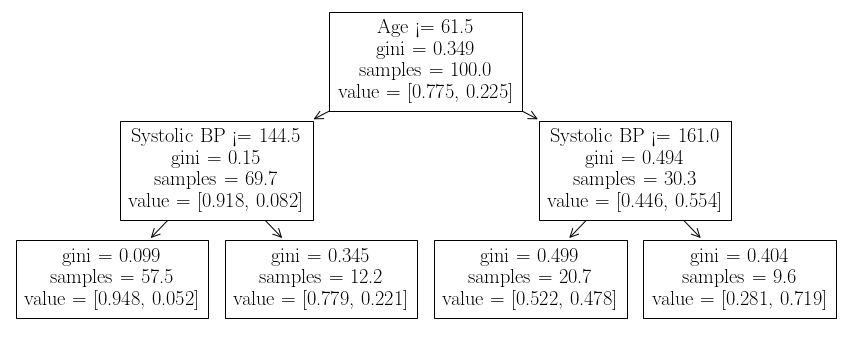

In [29]:
fig, ax = plt.subplots(figsize = (15,6))
ax = tree.plot_tree(dt, feature_names=col_labels, filled = False, proportion = True)
plt.show()

In [30]:
dt_feature_importance = dt.feature_importances_
dt_sorted_idx = dt_feature_importance.argsort()

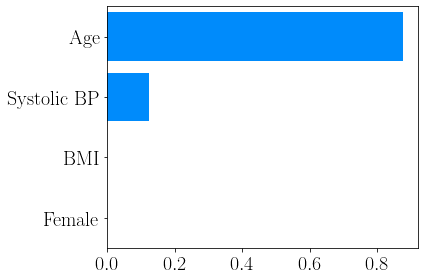

In [31]:
fig, ax = plt.subplots(1,1)
ax1 = sns.barplot(x = dt_feature_importance[dt_sorted_idx][::-1], y = np.array(col_labels)[dt_sorted_idx][::-1], color=shap_blue, saturation=1, ax= ax)
ax1.tick_params(axis = 'both', labelsize =20)
fig.tight_layout()
plt.show()

In [32]:
dt.tree_.impurity[1]*dt.tree_.n_node_samples[1]/1000 + dt.tree_.impurity[4]*dt.tree_.n_node_samples[4]/1000

0.2543801582453798

In [33]:
0.15*0.697 + 0.494*0.303

0.25423199999999996

In [34]:
0.349-0.254

0.09499999999999997

In [35]:
0.099*0.575+0.345*0.122 + 0.494*0.303

0.24869699999999997

In [36]:
0.254-0.249

0.0050000000000000044

In [37]:
0.099*0.575+0.345*0.122+0.499*0.207+0.404*0.096

0.241092

In [38]:
0.249-0.241

0.008000000000000007

In [39]:
0.005+0.008

0.013000000000000001

In [40]:
0.095/(0.095+0.013)

0.8796296296296297

In [41]:
0.013/(0.095+0.013)

0.12037037037037036

In [42]:
dt.feature_importances_

array([0.        , 0.87611161, 0.12388839, 0.        ])

## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf = RandomForestClassifier(n_estimators=200, max_depth=2, max_features='sqrt', random_state=42, oob_score=True, criterion = 'gini')
rf.fit(X_train, y_train)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=200,
                       oob_score=True, random_state=42)

In [45]:
feature_importance = rf.feature_importances_
sorted_idx = feature_importance.argsort()

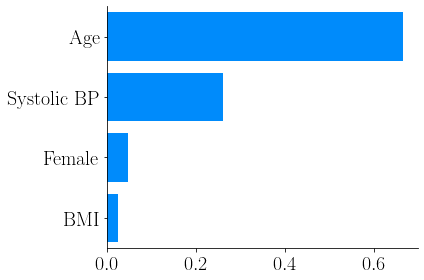

In [47]:
fig, ax = plt.subplots(1,1)
ax1 = sns.barplot(x = feature_importance[sorted_idx][::-1], y = np.array(col_labels)[sorted_idx][::-1], color=shap_blue, saturation=1, ax= ax)
ax1.tick_params(axis = 'both', labelsize =20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()

In [48]:
dt1 = DecisionTreeClassifier(max_depth = 8)
dt2 = DecisionTreeClassifier(max_depth = 8)
rf1 = RandomForestClassifier(max_depth = 8)
rf2 = RandomForestClassifier(max_depth = 8)

In [49]:
dt1.fit(X_train.iloc[:900,:], y_train[:900])
dt2.fit(X_train.iloc[100:,:], y_train[100:])
rf1.fit(X_train.iloc[:900,:], y_train[:900])
rf2.fit(X_train.iloc[100:,:], y_train[100:])

RandomForestClassifier(max_depth=8)

In [50]:
tree1_pred = dt1.predict_proba(X_train.iloc[400:600])
tree2_pred = dt2.predict_proba(X_train.iloc[400:600])
rf1_pred = rf1.predict_proba(X_train.iloc[400:600])
rf2_pred = rf2.predict_proba(X_train.iloc[400:600])

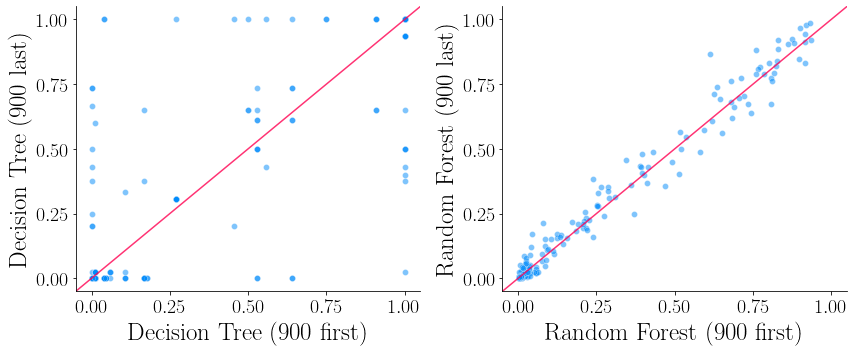

In [51]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
ax1 = sns.scatterplot(x = tree1_pred[:,1], y = tree2_pred[:,1], ax = ax[0], color = shap_blue, alpha = 0.5)
ax1.plot([0, 1], [0, 1], color = shap_red, transform=ax1.transAxes, alpha = 0.8)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xticks([0,0.25,0.5, 0.75,1])
ax1.set_yticks([0,0.25,0.5, 0.75,1])
ax1.set_xlabel('Decision Tree (900 first)', fontsize = 25)
ax1.set_ylabel('Decision Tree (900 last)', fontsize = 25)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = sns.scatterplot(x = rf1_pred[:,1], y =rf2_pred[:,1], ax = ax[1], color = shap_blue, alpha = 0.5)
ax2.plot([0, 1], [0, 1], color = shap_red, transform=ax2.transAxes,alpha = 0.8)
ax2.tick_params(axis = 'both', labelsize = 20)
ax2.set_xlabel('Random Forest (900 first)', fontsize = 25)
ax2.set_ylabel('Random Forest (900 last)', fontsize = 25)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim(-0.05, 1.05)
ax2.set_ylim(-0.05, 1.05)
ax2.set_xticks([0,0.25,0.5, 0.75,1])
ax2.set_yticks([0,0.25,0.5, 0.75,1])
fig.tight_layout()
plt.show()

## Random Planted Forest

In [52]:
from RPF_EstimatorV3 import RandomPlantedForestV3

In [78]:
rpf = RandomPlantedForestV3(n_trees=20, t_try=0.3, splits=10, split_try=5, categorical_variables=[0], cores = 2)
rpf.fit(X_train, y_train)

RandomPlantedForestV3(categorical_variables=[0], cores=2, n_trees=20,
                      split_try=5, splits=10, t_try=0.3)

In [79]:
rpf.purify(X_train)

RandomPlantedForestV3(categorical_variables=[0], cores=2, n_trees=20,
                      split_try=5, splits=10, t_try=0.3)

In [80]:
pur_pred = rpf.predict_purified(X_train)

In [81]:
from functions.rpf_interpretations_feature_names import add_feature_names

In [82]:
pur_pred_clean = add_feature_names(pur_pred, col_labels)

In [83]:
pur_pred_clean.columns

Index(['Intercept', 'Age', 'Age__Systolic BP', 'Age__BMI', 'Systolic BP',
       'Systolic BP__BMI', 'BMI', 'Pred'],
      dtype='object')

In [84]:
X_train_clean = X_train.reset_index(drop = True)

In [85]:
os.chdir(sys.path[0])

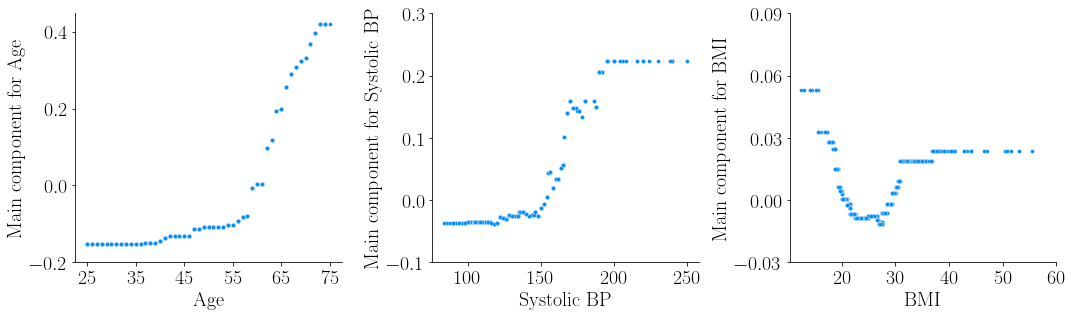

In [88]:
fig, ax = plt.subplots(1,3, figsize = (15, 4.5))
ax1 = sns.scatterplot(x = X_train_clean.iloc[:,1], y = pur_pred_clean['Age'], color = shap_blue, ax = ax[0], s = 15)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.set_xticks([25,35,45,55,65,75])
ax1.set_yticks([-0.2, 0, 0.2, 0.4])
ax1.set_ylabel('Main component for Age', fontsize =20)
ax1.set_xlabel('Age', fontsize = 20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = sns.scatterplot(x = X_train_clean.iloc[:,2], y = pur_pred_clean['Systolic BP'], color = shap_blue, ax = ax[1], s = 15)
ax2.tick_params(axis = 'both', labelsize = 20)
ax2.set_xticks([100,150,200,250])
ax2.set_yticks([-0.1, 0, 0.1, 0.2, 0.3])
ax2.set_ylabel('Main component for Systolic BP', fontsize =20)
ax2.set_xlabel('Systolic BP', fontsize = 20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = sns.scatterplot(x = X_train_clean.iloc[:,3], y = pur_pred_clean['BMI'], color = shap_blue, ax = ax[2], s = 15)
ax3.tick_params(axis = 'both', labelsize = 20)
ax3.set_xticks([20,30,40,50,60])
ax3.set_yticks([-0.03,0,0.03,0.06,0.09])
ax3.set_ylabel('Main component for BMI', fontsize =20)
ax3.set_xlabel('BMI', fontsize = 20)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()

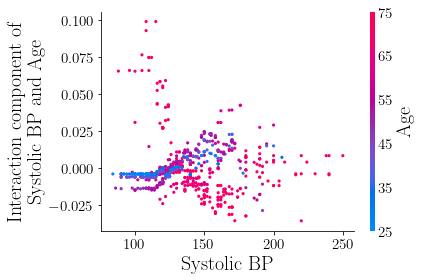

In [94]:
fig, ax1 = plt.subplots(1,1, figsize = (6,4))
ax2 = ax1.scatter(x=X_train.iloc[:,2], y = pur_pred_clean['Age__Systolic BP'], c = X_train.iloc[:,1], 
                      cmap = shap_cmap, edgecolor = 'none', s = 10)
ax1.tick_params(labelsize = 15)
ax1.set_xlabel('Systolic BP', fontsize = 20)
ax1.set_ylabel('Interaction component of \n Systolic BP and Age', fontsize = 20)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
cbar = plt.colorbar(ax2, ax = ax1, aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([25,35,45,55,65,75])
cbar.set_label('Age', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout()
plt.show()

In [95]:
test_obs = X_train.iloc[422:423, :]
test_obs

,sex_isFemale,age,systolic_blood_pressure,BMI
924,1,67,105.0,23.95


In [96]:
rpf.predict_purified(test_obs)

,Intercept,[1.0],"[1.0, 2.0]","[1.0, 3.0]",[2.0],"[2.0, 3.0]",[3.0],Pred
0,0.227923,0.289597,0.07639,-0.001432,-0.035542,0.001916,-0.008449,0.550403


## PD / ICE / ALE plots

In [97]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

In [98]:
rf_full = RandomForestClassifier(max_depth = 4, random_state=42)
rf_full.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [99]:
sbp_pd, sbp_axes = partial_dependence(rf_full, X_train, 2)

A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.


In [100]:
sbp_unique = pd.DataFrame({'sbp':np.arange(X_train.systolic_blood_pressure.min(), X_train.systolic_blood_pressure.max() +1)})
age_unique = pd.DataFrame({'age':np.arange(X_train.age.min(), X_train.age.max()+1)})
age_sbp_grid = age_unique.merge(sbp_unique, how = 'cross').assign(pred = np.nan)

In [101]:
for i in range(age_sbp_grid.shape[0]):
    X_copy = X_train.copy()
    X_copy.iloc[:, [1,2]] = age_sbp_grid.iloc[i,[0,1]]
    pred = rf_full.predict_proba(X_copy)[:,1].mean()
    age_sbp_grid.loc[i, 'pred'] = pred

In [102]:
age_sbp_pd = age_sbp_grid.pivot(columns='sbp', values = 'pred', index = 'age').to_numpy()

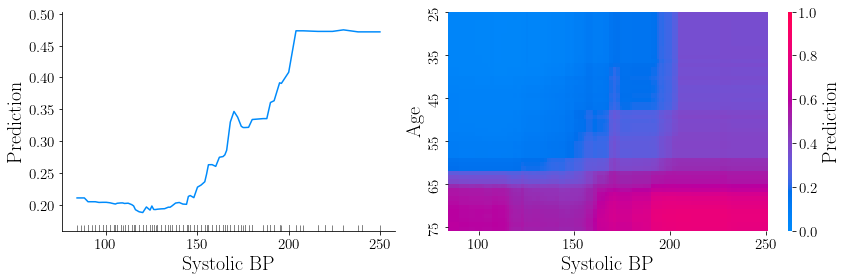

In [103]:
fig, ax = plt.subplots(1,2,figsize = (12,4), gridspec_kw={'width_ratios': [1, 1.2]})
ax1 = sns.lineplot(x =sbp_axes[0], y = sbp_pd[0], color = shap_blue, ax=ax[0])
sns.rugplot(x=X_train.systolic_blood_pressure, ax = ax[0], color = shap_gray, clip_on = False)
ax1.set_xticks([100,150,200,250])
#ax1.set_yticks([0,0.3,0.6,0.9])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Systolic BP', fontsize = 20)
ax1.set_ylabel('Prediction', fontsize = 20)
ax1.tick_params(axis = 'both', labelsize  =15)
ax2 = sns.heatmap(age_sbp_pd, cmap = shap_cmap, cbar_kws={'aspect':50}, vmin = 0, vmax = 1, ax = ax[1])
cbar = ax2.collections[0].colorbar
cbar.ax.set_ylabel('Prediction', fontsize = 20)
cbar.ax.tick_params(labelsize = 15)
ax2.set_yticks([0,10,20,30,40,50])
ax2.set_yticklabels(age_unique.age[[0,10,20,30,40,50]])
ax2.set_ylabel('Age', fontsize = 20)
ax2.set_xticks([16,66,116,166])
ax2.set_xticklabels(sbp_unique.sbp[[16,66,116,166]].astype(int), rotation = 360)
ax2.set_xlabel('Systolic BP', fontsize = 20)
ax2.tick_params(axis = 'both',labelsize = 15)
fig.tight_layout()
plt.show()

In [104]:
test2 = X_train.groupby(['age', 'systolic_blood_pressure']).agg(Count = pd.NamedAgg(column = 'BMI', aggfunc = 'count')).reset_index()
test2[test2.systolic_blood_pressure > 200]

,age,systolic_blood_pressure,Count
142,34,206.0,1
541,65,216.0,1
542,65,240.0,1
560,66,220.0,1
604,68,220.0,1
605,68,238.0,1
606,68,240.0,1
607,68,250.0,1
645,70,208.0,1
646,70,224.0,1


In [105]:
sbp_ice = partial_dependence(rf_full, X_train, 2, method = 'brute', kind = 'individual')

In [106]:
x_anchor = X_train.copy()
x_anchor.iloc[:, 2] =X_train.iloc[:, 2].min()
sbp_anche = rf_full.predict_proba(x_anchor)[:,1]
centered_ice = sbp_ice['individual'][0] - sbp_anche.reshape(1000,1)
centered_pd = centered_ice.mean(0)

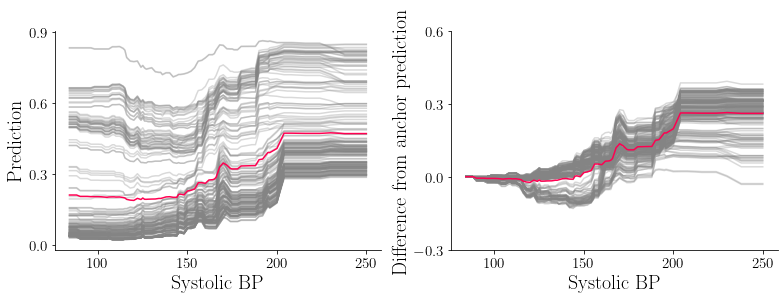

In [107]:
fig, ax = plt.subplots(1,2, figsize = (11,4))
for i in range(200):
    ax[0].plot(sbp_ice['values'][0],  sbp_ice['individual'][0][i], color = shap_gray, alpha = 0.3)
ax[0].plot(sbp_axes[0], sbp_pd[0], color = shap_red)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_xticks([100,150,200,250])
ax[0].set_yticks([0,0.3,0.6,0.9])
ax[0].tick_params(axis = 'both', labelsize = 15)
ax[0].set_xlabel('Systolic BP', fontsize = 20)
ax[0].set_ylabel('Prediction', fontsize = 20)
for i in range(200):
    ax[1].plot(sbp_ice['values'][0],  centered_ice[i], color = shap_gray, alpha = 0.3)
ax[1].plot(sbp_axes[0], centered_pd, color = shap_red)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xticks([100,150,200,250])
ax[1].set_yticks([-0.3,0,0.3,0.6])
ax[1].tick_params(axis = 'both', labelsize = 15)
ax[1].set_xlabel('Systolic BP', fontsize = 20)
ax[1].set_ylabel('Difference from anchor prediction', fontsize = 20)
fig.tight_layout()
plt.show()

In [108]:
bins = 15
sbp_train = X_train.iloc[:, 2].to_numpy()
sbp_quantiles = np.quantile(sbp_train, np.linspace(0,1,bins+1), interpolation="lower")
indices = np.clip(np.digitize(sbp_train, sbp_quantiles, right=True) - 1, 0, None)
predictions = []
for offset in range(2):
    mod_train_set = X_train.copy()
    mod_train_set.iloc[:,2] = sbp_quantiles[indices + offset]
    predictions.append(rf_full.predict_proba(mod_train_set)[:,1])
effects = predictions[1] - predictions[0]
index_groupby = pd.DataFrame({"index": indices, "effects": effects}).groupby("index")
mean_effects = index_groupby.mean().to_numpy().flatten()
ale = np.array([*np.cumsum(mean_effects)]) #np.array([0, *np.cumsum(mean_effects)])
#ale = (ale[1:] + ale[:-1]) / 2
ale -= np.sum(ale * index_groupby.size() / X_train.shape[0])
#ale_centers = (sbp_quantiles[1:]+ sbp_quantiles[:-1])/2

In [109]:
ale_axes = np.repeat(sbp_quantiles, 2)[1:-1]
sbp_ale = np.repeat(ale,2)

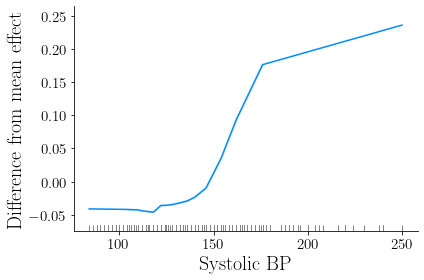

In [110]:
fig, ax=  plt.subplots(1,1, figsize = (6,4))
ax = sns.lineplot(x = ale_axes, y = sbp_ale, color = shap_blue, ci = False)
sns.rugplot(x = X_train.systolic_blood_pressure, ax= ax, color = shap_gray)
#ax.set_yticks([-0.3,0,0.3, 0.6])
ax.set_xticks([100,150,200, 250])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Systolic BP', fontsize = 20)
ax.set_ylabel('Difference from mean effect', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 15)
fig.tight_layout()
fig.savefig('Results_NEW/Figs/toy_ale_plots1.png')
plt.show()

## Permutation Feature Importance

In [111]:
from sklearn.inspection import permutation_importance

In [112]:
feature_importance_full = rf_full.feature_importances_
sorted_idx_full = feature_importance_full.argsort()

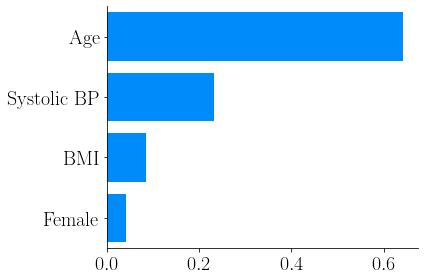

In [113]:
fig, ax = plt.subplots(1,1)
ax1 = sns.barplot(x = feature_importance_full[sorted_idx_full][::-1], y = np.array(col_labels)[sorted_idx_full][::-1], color=shap_blue, saturation=1, ax= ax)
ax1.tick_params(axis = 'both', labelsize =20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()

In [114]:
perm = permutation_importance(rf_full, X_test, y_test, n_repeats=10, scoring  ='neg_log_loss',random_state=42)
medians = np.median(perm.importances, axis = 1)
sorted_medians = np.argsort(medians)

In [115]:
perm_train = permutation_importance(rf_full, X_train, y_train, n_repeats=10, scoring = 'neg_log_loss', random_state=42)
medians_train = np.median(perm_train.importances, axis = 1)
sorted_medians_train = np.argsort(medians_train)

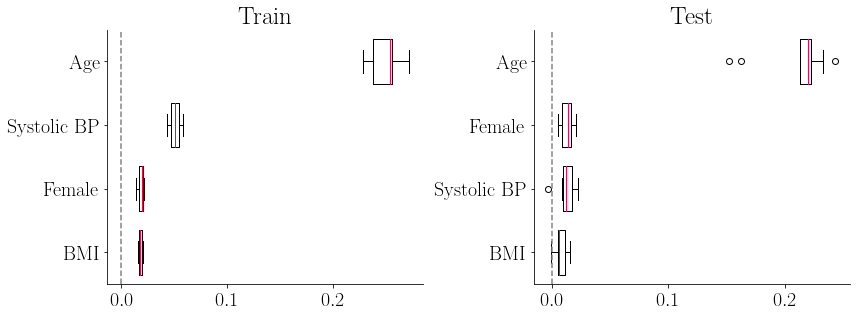

In [116]:
fig, ax = plt.subplots(1,2, figsize = (12,4.5))
ax[0].boxplot(x = perm_train.importances[sorted_medians_train].T, vert = False, labels = np.array(col_labels)[sorted_medians_train], 
            medianprops = {'color': shap_red}, widths = 0.7)
ax[0].axvline(0, ls = '--', color = shap_gray)
ax[0].tick_params(axis = 'both', labelsize = 20)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_title('Train', fontsize = 25)
ax[1].boxplot(x = perm.importances[sorted_medians].T, vert = False, labels = np.array(col_labels)[sorted_medians], 
            medianprops = {'color': shap_red}, widths = 0.7)
ax[1].axvline(0, ls = '--', color = shap_gray)
ax[1].tick_params(axis = 'both', labelsize = 20)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_title('Test', fontsize = 25)
fig.tight_layout()
plt.show()

## Shapley

In [117]:
import math

In [118]:
empty_model = np.mean(y_train)
empty_model

0.225

In [119]:
age_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train.age.to_numpy().reshape(-1, 1),y_train)
bp_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train.systolic_blood_pressure.to_numpy().reshape(-1, 1),y_train)
bmi_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train.BMI.to_numpy().reshape(-1, 1),y_train)

In [88]:
age_bmi_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train[['age', 'BMI']],y_train)
age_bp_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train[['age', 'systolic_blood_pressure']],y_train)
bp_bmi_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train[['systolic_blood_pressure', 'BMI']],y_train)

In [89]:
full_model = DecisionTreeClassifier(max_depth=4, random_state=42).fit(X_train[['age', 'BMI', 'systolic_blood_pressure']],y_train)

In [90]:
test_obs

,sex_isFemale,age,systolic_blood_pressure,BMI
924,1,67,105.0,23.95


In [91]:
preds = pd.DataFrame({'Model': ['Empty', 'Age', 'Systolic BP', 'BMI', 'Age, Systolic BP', 'Age, BMI', 'Systolic BP, BMI', 'Full'],
                      'Predictions': [
                          empty_model,
                          age_model.predict_proba(test_obs[['age']])[0][1],
                          bp_model.predict_proba(test_obs[['systolic_blood_pressure']])[0][1],
                          bmi_model.predict_proba(test_obs[['BMI']])[0][1],
                          age_bp_model.predict_proba(test_obs[['age', 'systolic_blood_pressure']])[0][1],
                          age_bmi_model.predict_proba(test_obs[['age', 'BMI']])[0][1],
                          bp_bmi_model.predict_proba(test_obs[['systolic_blood_pressure', 'BMI']])[0][1],
                          full_model.predict_proba(test_obs[['age', 'BMI', 'systolic_blood_pressure']])[0][1]
                        ]})

X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names


In [92]:
preds

,Model,Predictions
0,Empty,0.225000
1,Age,0.517241
2,Systolic BP,0.084239
3,BMI,0.155039
4,"Age, Systolic BP",0.600000
5,"Age, BMI",0.466667
6,"Systolic BP, BMI",0.084239
7,Full,0.600000


In [93]:
w_30 = math.factorial(0)*math.factorial(3-0-1) / math.factorial(3) #(1/3)
w_31 = math.factorial(1)*math.factorial(3-1-1) / math.factorial(3) #(1/6)
w_32 = math.factorial(2)*math.factorial(3-2-1) / math.factorial(3) #(1/3)

In [94]:
mc_age_empty = float(preds.loc[preds.Model == 'Age','Predictions']) -float(preds.loc[preds.Model == 'Empty','Predictions'])
mc_age_bp = float(preds.loc[preds.Model == 'Age, Systolic BP','Predictions']) -float(preds.loc[preds.Model == 'Systolic BP','Predictions'])
mc_age_bmi = float(preds.loc[preds.Model == 'Age, BMI','Predictions']) -float(preds.loc[preds.Model == 'BMI','Predictions'])
mc_full_bp_bmi = float(preds.loc[preds.Model == 'Full', 'Predictions']) - float(preds.loc[preds.Model == 'Systolic BP, BMI','Predictions'])

In [95]:
shap_age = w_30*mc_age_empty + w_31*mc_age_bp + w_31*mc_age_bmi + w_32*mc_full_bp_bmi
shap_age

0.407232212382181

In [96]:
mc_bp_empty = float(preds.loc[preds.Model == 'Systolic BP','Predictions']) -float(preds.loc[preds.Model == 'Empty','Predictions'])
mc_bp_age = float(preds.loc[preds.Model == 'Age, Systolic BP','Predictions']) -float(preds.loc[preds.Model == 'Age','Predictions'])
mc_bp_bmi = float(preds.loc[preds.Model == 'Systolic BP, BMI','Predictions']) -float(preds.loc[preds.Model == 'BMI','Predictions'])
mc_full_age_bmi = float(preds.loc[preds.Model == 'Full', 'Predictions']) - float(preds.loc[preds.Model == 'Age, BMI','Predictions'])

In [97]:
shap_bp = w_30*mc_bp_empty + w_31*mc_bp_age + w_31*mc_bp_bmi + w_32*mc_full_age_bmi
shap_bp

-0.00048268017154216164

In [98]:
mc_bmi_empty = float(preds.loc[preds.Model == 'BMI','Predictions']) -float(preds.loc[preds.Model == 'Empty','Predictions'])
mc_bmi_age = float(preds.loc[preds.Model == 'Age, BMI','Predictions']) -float(preds.loc[preds.Model == 'Age','Predictions'])
mc_bmi_bp = float(preds.loc[preds.Model == 'Systolic BP, BMI','Predictions']) -float(preds.loc[preds.Model == 'Systolic BP','Predictions'])
mc_full_age_bp = float(preds.loc[preds.Model == 'Full', 'Predictions']) - float(preds.loc[preds.Model == 'Age, Systolic BP','Predictions'])

In [99]:
shap_bmi = w_30*mc_bmi_empty + w_31*mc_bmi_age + w_31*mc_bmi_bp + w_32*mc_full_age_bp
shap_bmi

-0.03174953221063887

In [100]:
shap_age + shap_bp + shap_bmi

0.37499999999999994

In [101]:
float(preds.loc[preds.Model == 'Full', 'Predictions']) - float(preds.loc[preds.Model == 'Empty', 'Predictions'])

0.375

In [102]:
test_obs

,sex_isFemale,age,systolic_blood_pressure,BMI
924,1,67,105.0,23.95


In [103]:
np.mean(full_model.predict_proba(X_train[['age', 'BMI', 'systolic_blood_pressure']])[:,1])

0.225

In [104]:
empty_model

0.225

In [105]:
import shap

In [106]:
nu_sbp = 0.697*5.2+0.303*47.8
nu_empty = 22.5
nu_age = 55.4
nu_full = 47.8

In [107]:
nu_sbp

18.1078

In [108]:
w_1 = 1/3
w_2 = 2/3

In [109]:
(1/2)*(nu_age - nu_empty) + (1/2)*(nu_full - nu_sbp)

31.296099999999996

In [110]:
(1/2)*(nu_sbp- nu_empty) + (1/2)*(nu_full - nu_age)

-5.9961

In [111]:
nu_full - nu_empty

25.299999999999997

In [120]:
explainer_path = shap.TreeExplainer(rf_full)
shap_values_path = explainer_path(X_train)

In [121]:
explainer_inter = shap.TreeExplainer(rf_full, data = X_train)
shap_values_inter = explainer_inter(X_train, check_additivity = False)

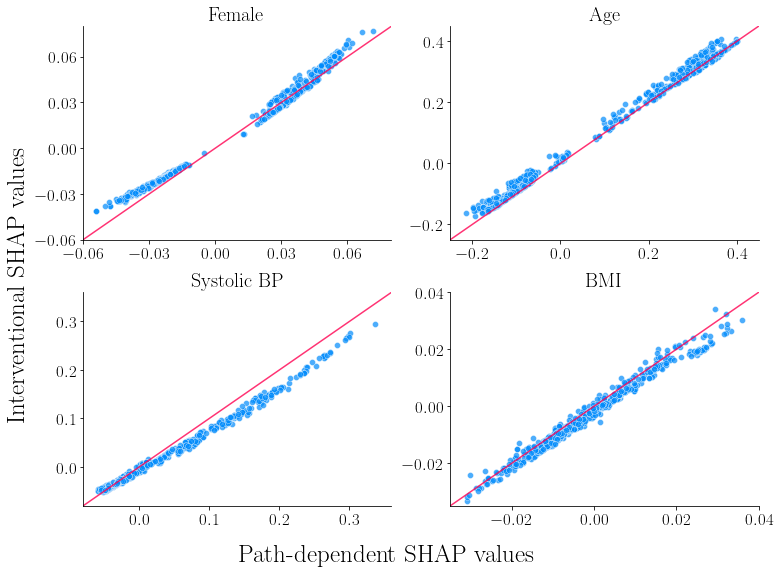

In [122]:
fig, ax = plt.subplots(2,2, figsize = (11,8))
ax1 = sns.scatterplot(x = shap_values_path.values[:,0,1], y = shap_values_inter.values[:,0,1], ax = ax[0,0], color = shap_blue, alpha = 0.7)
ax1.plot([-1, 1], [-1, 1],c = shap_red, alpha = 0.8)#, transform=ax1.transAxes)
ax1.tick_params(axis = 'both', labelsize = 17)
ax1.set_title('Female', fontsize = 20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(-0.06, 0.08)
ax1.set_ylim(-0.06, 0.08)
ax1.set_xticks([-0.06, -0.03, 0, 0.03,  0.06])
ax1.set_yticks([-0.06, -0.03, 0, 0.03,  0.06])
ax2 = sns.scatterplot(x = shap_values_path.values[:,1,1], y = shap_values_inter.values[:,1,1], ax = ax[0,1], color = shap_blue, alpha = 0.7)
ax2.plot([-1, 1], [-1, 1],c = shap_red, alpha = 0.8) #, transform=ax2.transAxes)
ax2.tick_params(axis = 'both', labelsize = 17)
ax2.set_title('Age', fontsize = 20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim(-0.25, 0.45)
ax2.set_ylim(-0.25, 0.45)
ax2.set_xticks([-0.2, 0, 0.2,  0.4])
ax2.set_yticks([-0.2, 0, 0.2,  0.4])
ax3 = sns.scatterplot(x = shap_values_path.values[:,2,1], y = shap_values_inter.values[:,2,1], ax = ax[1,0], color = shap_blue, alpha = 0.7)
ax3.plot([-1, 1], [-1, 1],c = shap_red, alpha = 0.8)#, transform=ax3.transAxes)
ax3.tick_params(axis = 'both', labelsize = 17)
ax3.set_title('Systolic BP', fontsize = 20)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlim(-0.08, 0.36)
ax3.set_ylim(-0.08, 0.36)
ax3.set_xticks([ 0, 0.1,  0.2, 0.3])
ax3.set_yticks([ 0, 0.1,  0.2, 0.3])
ax4 = sns.scatterplot(x = shap_values_path.values[:,3,1], y = shap_values_inter.values[:,3,1], ax = ax[1,1], color = shap_blue, alpha = 0.7)
ax4.plot([-1, 1], [-1, 1],c = shap_red, alpha = 0.8)#, transform=ax4.transAxes)
ax4.tick_params(axis = 'both', labelsize = 17)
ax4.set_title('BMI', fontsize = 20)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_xlim(-0.035, 0.04)
ax4.set_ylim(-0.035, 0.04)
ax4.set_xticks([-0.02, 0, 0.02,  0.04])
ax4.set_yticks([-0.02, 0, 0.02,  0.04])
fig.supylabel('Interventional SHAP values', fontsize = 25)
fig.supxlabel('Path-dependent SHAP values', fontsize = 25)
fig.tight_layout()
plt.show()

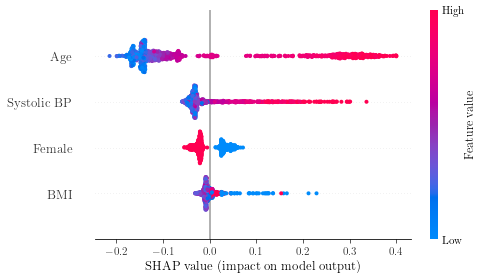

In [123]:
shap.summary_plot(shap_values_path.values[:,:,1], features=X_train, feature_names=col_labels, show = False)
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(7,4)
fig.tight_layout()
plt.show()

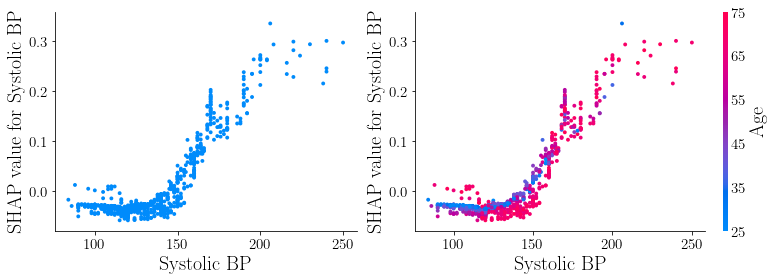

In [148]:
fig, ax = plt.subplots(1,2, figsize = (11,4), gridspec_kw={'width_ratios': [1, 1.2]})
ax[0].scatter(X_train.iloc[:,2], shap_values_path.values[:,2, 1], color = shap_blue, edgecolor = 'none', s = 15)
ax[0].set_xticks([100,150,200,250])
ax[0].set_ylim(-0.08, 0.36)
ax[0].set_yticks([0, 0.1, 0.2, 0.3])
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Systolic BP', fontsize = 20)
ax[0].set_ylabel('SHAP value for Systolic BP', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax1 = ax[1].scatter(X_train.iloc[:,2], shap_values_path.values[:,2, 1], c = X_train.iloc[:,1], 
                      cmap = shap_cmap, edgecolor = 'none', s = 15)
ax[1].set_xticks([100,150,200,250])
ax[1].set_ylim(-0.08, 0.36)
ax[1].set_yticks([0, 0.1, 0.2, 0.3])
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('Systolic BP', fontsize = 20)
ax[1].set_ylabel('SHAP value for Systolic BP', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax1, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([25,35,45,55,65,75])
cbar.set_label('Age', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout()
plt.show()

In [149]:
shap_interaction_path = explainer_path.shap_interaction_values(X_train)

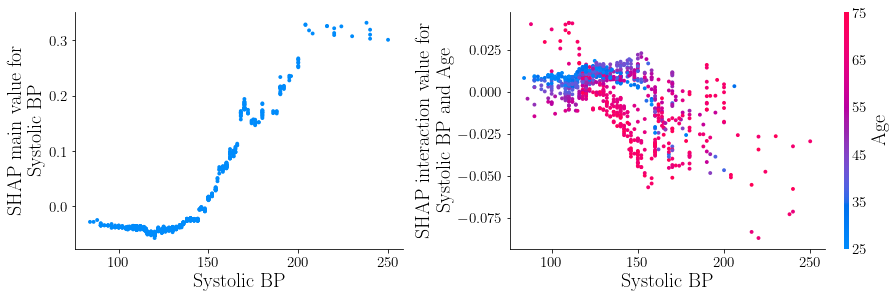

In [163]:
fig, ax = plt.subplots(1,2, figsize = (13,4.5), gridspec_kw={'width_ratios': [1,1.2]})
ax1 = ax[0].scatter(X_train.iloc[:,2], shap_interaction_path[1][:,2, 2], color = shap_blue, edgecolor = 'none', s = 15)
ax[0].tick_params(labelsize = 15)
ax[0].set_xlabel('Systolic BP', fontsize = 20)
ax[0].set_ylabel('SHAP main value for \n Systolic BP', fontsize = 20)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax1 = ax[1].scatter(X_train.iloc[:,2], shap_interaction_path[1][:,2, 1], c = X_train.iloc[:,1], 
                      cmap = shap_cmap, edgecolor = 'none', s = 15)
ax[1].tick_params(labelsize = 15)
ax[1].set_xlabel('Systolic BP', fontsize = 20)
ax[1].set_ylabel('SHAP interaction value for \n Systolic BP and Age', fontsize = 20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
cbar = plt.colorbar(ax1, ax = ax[1], aspect = 50)
cbar.ax.tick_params(labelsize=15, size = 0)
cbar.set_ticks([25,35,45,55,65,75])
cbar.set_label('Age', fontsize = 20)
cbar.outline.set_visible(False)
fig.tight_layout(pad = 2)
plt.show()

## Evaluation Metrics

In [308]:
from sklearn.metrics import roc_curve, roc_auc_score

In [291]:
rf_fpr_train, rf_tpr_train, rf_thresh_train = roc_curve(y_train, rf_full.predict_proba(X_train)[:,1])
rf_fpr_test, rf_tpr_test, rf_thresh_test = roc_curve(y_test, rf_full.predict_proba(X_test)[:,1])
rpf_fpr_train, rpf_tpr_train, rpf_thresh_train = roc_curve(y_train, rpf.predict_proba(X_train)[:,1])
rpf_fpr_test, rpf_tpr_test, rpf_thresh_test = roc_curve(y_test, rpf.predict_proba(X_test)[:,1])

In [315]:
rf_train_auc = np.round(roc_auc_score(y_train, rf_full.predict_proba(X_train)[:,1]),4)
rpf_train_auc = np.round(roc_auc_score(y_train, rpf.predict_proba(X_train)[:,1]),4)

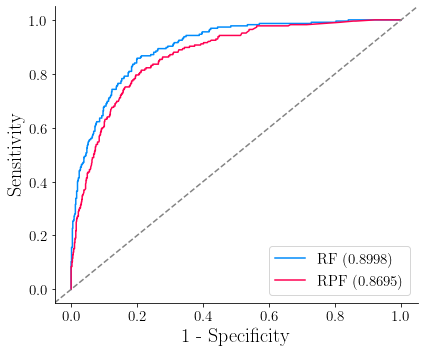

In [317]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
ax.plot(rf_fpr_train, rf_tpr_train, color = shap_blue, label = 'RF (' + str(rf_train_auc) + ')')
ax.plot(rpf_fpr_train, rpf_tpr_train, color = shap_red, label = 'RPF (' + str(rpf_train_auc) + ')')
ax.plot([0, 1], [0, 1], '--', color = shap_gray, transform=ax.transAxes)
ax.legend(fontsize = 15)
ax.set_xlabel('1 - Specificity', fontsize = 20)
ax.set_ylabel('Sensitivity', fontsize = 20)
ax.tick_params(axis = 'both', labelsize = 15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()